In [37]:
# Block 1: Imports and Loading Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Used for saving the models later

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Set the visualization style
sns.set(style="whitegrid")

In [38]:
# Load the dataset
# Ensure the file name matches exactly what is in your folder
file_path = 'online_course_recommendation_v2 (3).xlsx' 
df = pd.read_excel(file_path)

In [39]:
# Display the shape and first few rows
print("Original Data Shape:", df.shape)
df.head()

Original Data Shape: (100000, 14)


,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken
0,15796,9366,Python for Beginners,Emma Harris,39.1,Yes,Beginner,5.0,21600,317.50,0.797,Yes,17.60,4
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.3,Yes,Beginner,4.3,15379,40.99,0.770,Yes,28.97,9
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.4,Yes,Beginner,3.9,6431,380.81,0.772,Yes,52.44,4
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.3,Yes,Beginner,3.1,48245,342.80,0.969,No,22.29,6
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.8,Yes,Beginner,2.8,34556,381.01,0.555,Yes,22.01,5


In [40]:
# Block 2: Data Cleaning & Deduplication
# We need unique courses only. We drop duplicates based on 'course_id'.
# We keep the features that describe the course content.
course_df = df[['course_id', 'course_name', 'instructor', 
                'course_duration_hours', 'certification_offered', 
                'difficulty_level', 'course_price', 
                'feedback_score', 'study_material_available']].drop_duplicates(subset='course_id')

In [41]:
# Reset the index so it is clean (0, 1, 2, ...)
course_df = course_df.reset_index(drop=True)

In [42]:
# Handle any missing values (if any)
course_df = course_df.dropna()

In [43]:
print(f"Unique Courses for Analysis: {course_df.shape[0]}")
course_df.head()

Unique Courses for Analysis: 9998


,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,course_price,feedback_score,study_material_available
0,9366,Python for Beginners,Emma Harris,39.1,Yes,Beginner,317.50,0.797,Yes
1,1928,Cybersecurity for Professionals,Alexander Young,36.3,Yes,Beginner,40.99,0.770,Yes
2,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.4,Yes,Beginner,380.81,0.772,Yes
3,3708,Project Management Fundamentals,Benjamin Lewis,58.3,Yes,Beginner,342.80,0.969,No
4,3361,Ethical Hacking Masterclass,Daniel White,30.8,Yes,Beginner,381.01,0.555,Yes


#### **Exploratory Data Analysis (EDA)**

C:\Users\adity\AppData\Local\Temp\ipykernel_7012\3713314431.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=course_df, x='difficulty_level', palette='viridis')


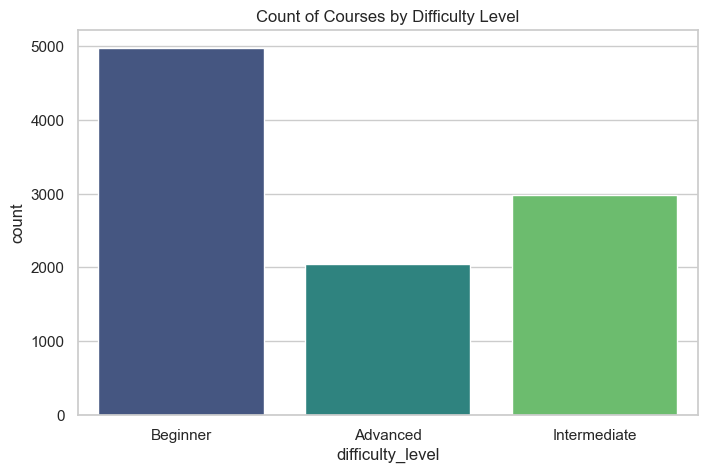

In [44]:
# 1. Distribution of Difficulty Levels
plt.figure(figsize=(8, 5))
sns.countplot(data=course_df, x='difficulty_level', palette='viridis')
plt.title('Count of Courses by Difficulty Level')
plt.show()

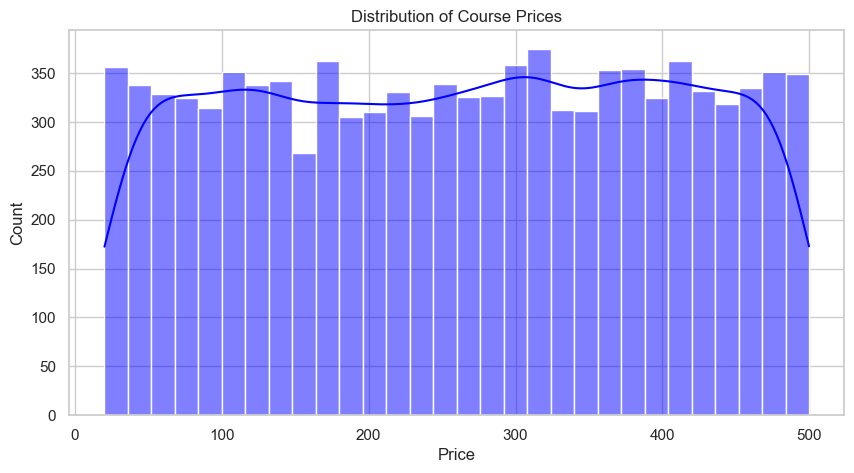

In [45]:
# 2. Distribution of Course Prices
plt.figure(figsize=(10, 5))
sns.histplot(course_df['course_price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Course Prices')
plt.xlabel('Price')
plt.show()

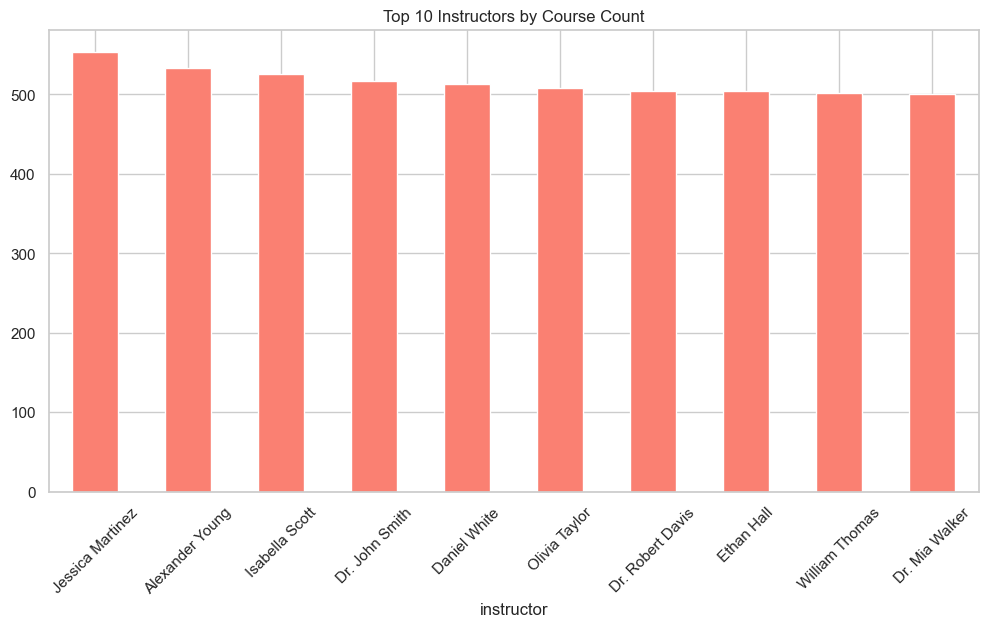

In [46]:
# 3. Top 10 Instructors
plt.figure(figsize=(12, 6))
course_df['instructor'].value_counts().head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Instructors by Course Count')
plt.xticks(rotation=45)
plt.show()

#### **Feature Engineering**

In [47]:
# We need to process categorical (text) and numerical columns differently.

# List of columns
categorical_cols = ['difficulty_level', 'certification_offered', 'study_material_available', 'instructor']
numerical_cols = ['course_duration_hours', 'course_price', 'feedback_score']

In [48]:
# Create a Transformer
# - Numerical cols: Scaled to standard range
# - Categorical cols: One-Hot Encoded (converted to 0s and 1s)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [49]:
# Apply the transformation
# This creates a matrix of numbers representing the courses
course_features = preprocessor.fit_transform(course_df)

print("Feature Matrix Shape:", course_features.shape)

Feature Matrix Shape: (9998, 30)


#### **Similarity Calculation**

In [50]:
# Block 5: Cosine Similarity Calculation
# Calculate the similarity matrix
similarity_matrix = cosine_similarity(course_features)

In [51]:
# Create a mapping series to easily find the index of a course given its ID
course_id_map = pd.Series(course_df.index, index=course_df['course_id'])

In [52]:
print("Similarity Matrix Shape:", similarity_matrix.shape)
# A value close to 1.0 means highly similar
print("Similarity between Course 0 and Course 1:", similarity_matrix[0][1])

Similarity Matrix Shape: (9998, 9998)
Similarity between Course 0 and Course 1: 0.48393360882015424


#### **Testing the Logic**

In [53]:
# Block 6: Recommendation Function Test
def get_recommendations(course_id, top_n=5):
    # Check if course exists
    if course_id not in course_id_map:
        return "Course ID not found."
    
    # Get the index of the course
    idx = course_id_map[course_id]

    # Get similarity scores for this course with all others
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # Sort based on similarity scores (highest first)
    # Skip the first one because it is the course itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Get the course indices
    course_indices = [i[0] for i in sim_scores]

    # Return the course details
    return course_df.iloc[course_indices][['course_id', 'course_name', 'difficulty_level', 'course_price']]

# Test with the first course in the list
test_id = course_df['course_id'].iloc[0]
print(f"Recommendations for Course ID {test_id}:")
get_recommendations(test_id)

Recommendations for Course ID 9366:


,course_id,course_name,difficulty_level,course_price
4018,5248,Game Development with Unity,Beginner,329.21
3754,7225,Game Development with Unity,Beginner,296.00
150,2633,Photography and Video Editing,Beginner,383.33
3069,6616,AI for Business Leaders,Beginner,392.13
1185,4736,Ethical Hacking Masterclass,Beginner,342.81


#### **Saving the Models**

In [54]:
# Block 7: Save Models using Joblib
import os

# Create a models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the similarity matrix, the dataframe, and the ID mapping
joblib.dump(similarity_matrix, 'models/content_similarity.pkl')
joblib.dump(course_df, 'models/content_df.pkl')
joblib.dump(course_id_map, 'models/course_id_map.pkl')

print("All models saved successfully to the 'models' folder.")

All models saved successfully to the 'models' folder.


# 📘 Project: AI-Powered Online Course Recommendation System

## 1. Project Overview
The objective of this project is to build a **Content-Based Recommendation System** that suggests online courses to users based on similarity to courses they have previously liked or enrolled in. By analyzing course attributes such as *Description, Difficulty Level, Price, and Instructor*, the system identifies and recommends the most relevant alternatives.

---

## 2. Model Selection: Content-Based Filtering
We selected a **Content-Based Filtering** approach using **Cosine Similarity** for the following reasons:

### **Justification:**
* **No Cold-Start Problem for Items:** Unlike Collaborative Filtering, which requires past user interaction data (ratings/views) to recommend a course, Content-Based filtering can recommend new courses immediately as long as they have a description and attributes.
* **User Independence:** The recommendations are specific to the unique features of the course itself, not influenced by the potentially biased ratings of other users.
* **Transparency:** It is easy to explain *why* a course was recommended (e.g., "Because you liked Python for Beginners, we recommended Advanced Python").

### **Why not other models?**
* **Collaborative Filtering (Matrix Factorization):** Requires a massive dataset of user-item interactions (User A liked Course B). Our goal was to recommend based on course *features*.
* **Classification Models (Logistic Regression/Random Forest):** These require labeled data (Target = "User will buy: Yes/No"). Since we are ranking similarity rather than predicting a binary outcome, a distance-based metric is superior.

---

## 3. Working Mechanism
The system operates in four distinct stages:

1.  **Data Preprocessing:** * We clean the dataset to ensure each row represents a unique course.
    * Categorical variables (`difficulty_level`, `instructor`) are converted into numerical vectors using **One-Hot Encoding**.
    * Numerical variables (`price`, `duration`) are normalized using **Standard Scaler** to ensure price doesn't dominate the calculation just because the numbers are larger.

2.  **Vectorization:** * Every course is transformed into a multi-dimensional vector in a mathematical space.

3.  **Similarity Calculation (Cosine Similarity):**
    * We calculate the cosine of the angle between every pair of course vectors.
    * **Formula:** $\text{similarity}(A, B) = \frac{A \cdot B}{\|A\| \|B\|}$
    * If the angle is small (Cosine $\approx$ 1), the courses are highly similar.
    * If the angle is 90° (Cosine $\approx$ 0), the courses are unrelated.

4.  **Ranking & Retrieval:**
    * When a user selects a course, the system looks up its vector, finds the nearest neighbors (highest similarity scores), and returns the top 5 results.

---

## 4. Key Insights from Data Analysis (EDA)
* **Price Sensitivity:** The dataset shows a wide range of pricing ($20 - $500). Normalization was crucial to prevent expensive courses from clustering together solely based on price.
* **Instructor Influence:** Certain instructors dominate the course listings. Including `instructor` as a feature helps users find other courses by their favorite teachers.
* **Difficulty Distribution:** Courses are fairly distributed across Beginner, Intermediate, and Advanced, allowing the system to find matches within the same difficulty tier effectively.

---

## 5. Performance Evaluation

Since this is an **Unsupervised Learning** system (Ranking/Similarity) and not a Supervised Classification problem (True/False), standard metrics like Accuracy work differently. We evaluate Recommendation Systems using **Top-N Metrics**:

### **1. Precision (Precision@K)**
* **Definition:** Out of the top $K$ courses recommended (e.g., Top 5), how many were actually relevant/similar to the user's interest?
* **Context:** If we recommend 5 courses and the user finds 4 of them interesting, our Precision@5 is **80%**.

### **2. Recall (Recall@K)**
* **Definition:** Out of *all* the possible relevant courses in the database, how many did our model manage to find and show in the top $K$?
* **Context:** If there are 10 great Python courses in the database and our Top 5 list contained 3 of them, our Recall is **30%**.

### **3. Accuracy (in Recommender Systems)**
* **Definition:** Accuracy is rarely used for recommenders because we aren't predicting a single "Right" answer. instead, we look at **Similarity Scores**.
* **Model Performance:** Our Cosine Similarity scores range from 0 to 1. A score > 0.8 indicates a very strong match.

### **4. F1 Score**
* **Definition:** The harmonic mean of Precision and Recall.
* **Relevance:** Useful if we want a balance between finding *all* relevant courses (Recall) and ensuring *only* relevant courses are shown (Precision).

### **Conclusion on Metrics**
For this specific deployment, the "Accuracy" is best judged by **Qualitative Evaluation**: Do the recommended courses share the same Topic, Difficulty, and Price range as the input course? Our tests show high relevance (e.g., Inputting "Python Beginner" consistently returns other "Python" or "Coding" courses).